In [ ]:
import os
import json
from PIL import Image, ImageOps, ImageEnhance
from random import randint, uniform
from PIL import ImageFilter

def augment_image(image, annotation):
    x_offset = randint(-10, 10)
    y_offset = randint(-10, 10)

    annotation["boundingBox"]["left"] += x_offset
    annotation["boundingBox"]["top"] += y_offset

    for point in annotation["points"]:
        point["x"] += x_offset
        point["y"] += y_offset

    angle = randint(-10, 10)
    image = image.rotate(angle, expand=True)

    brightness_factor = uniform(0.7, 1.3)
    image = ImageEnhance.Brightness(image).enhance(brightness_factor)
    radius = randint(1, 5)
    image = image.filter(ImageFilter.GaussianBlur(radius))
    return image, annotation

json_dir = "/content/drive/MyDrive/Aadhaar"
output_dir = "/content/drive/MyDrive/Aadhaar_augmented"

for json_file in os.listdir(json_dir):
    if json_file.endswith(".json"):
        with open(os.path.join(json_dir, json_file), "r") as file:
            data_entry = json.load(file)

        augmented_data_entry = data_entry.copy()
        image_path = "/content/drive/MyDrive/Aadhaar/"+ data_entry["asset"]["name"]
        annotations = data_entry["regions"]


        img = Image.open(image_path)
        augmented_annotations = []
        for annotation in annotations:
            augmented_image, augmented_annotation = augment_image(img.copy(), annotation)
            augmented_image = augmented_image.convert("RGB")
            augmented_annotations.append(augmented_annotation)
            filename = os.path.basename(image_path)
            image_name, image_extension = os.path.splitext(filename)
            output_path = os.path.join(output_dir, f"augmented_{image_name}{image_extension}")
            augmented_image.save(output_path)

        augmented_data_entry["regions"] = augmented_annotations
        augmented_data_entry["asset"]["name"]="augmented_"+data_entry["asset"]["name"]
        augmented_json_file = os.path.join(output_dir, f"{json_file}_augmented.json")
        with open(augmented_json_file, "w") as json_output:
            json.dump(augmented_data_entry, json_output)

print("Data augmentation and saving complete.")


Data augmentation and saving complete.


In [ ]:
import json
import os
class_mapping = {
   "Name":0,
   "D.O.B":1,
   "Gender":2,
   "Aadhar Number":3,
   "Image":4,
   "QR Code":5
}

def calculate_yolo_coordinates(annotation, image_width, image_height):
    left = annotation["boundingBox"]["left"]
    top = annotation["boundingBox"]["top"]
    width = annotation["boundingBox"]["width"]
    height = annotation["boundingBox"]["height"]

    x_center = (left + width / 2) / image_width
    y_center = (top + height / 2) / image_height

    x_width = width / image_width
    y_height = height / image_height

    return x_center, y_center, x_width, y_height

json_dir = "/content/drive/MyDrive/Aadhaar"

output_dir = "/content/drive/MyDrive/Aadhaar_yolo"

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for json_file in os.listdir(json_dir):
    if json_file.endswith(".json") or json_file.endswith(".json_augmented.json"):
        with open(os.path.join(json_dir, json_file), "r") as json_file:
            data_entry = json.load(json_file)

            image_path = "/content/drive/MyDrive/Aadhaar/"+data_entry["asset"]["name"]
            image_width = data_entry["asset"]["size"]["width"]
            image_height = data_entry["asset"]["size"]["height"]
            annotations = data_entry["regions"]
            filename = os.path.basename(image_path)
            image_name, image_extension = os.path.splitext(filename)
            yolo_annotation_path = os.path.join(output_dir, f"{image_name}.txt")

            with open(yolo_annotation_path, "w") as yolo_file:
                for annotation in annotations:
                    label = class_mapping.get(annotation["tags"][0], -1)
                    if label != -1:
                        x_center, y_center, x_width, y_height = calculate_yolo_coordinates(annotation, image_width, image_height)
                        line = f"{label} {x_center} {y_center} {x_width} {y_height}\n"
                        yolo_file.write(line)

print("Conversion to YOLO format complete.")


Conversion to YOLO format complete.


In [ ]:
!git clone https://github.com/AlexeyAB/darknet.git
%cd /content/darknet

Cloning into 'darknet'...
remote: Enumerating objects: 15833, done.
remote: Counting objects: 100% (294/294), done.
remote: Compressing objects: 100% (152/152), done.
remote: Total 15833 (delta 157), reused 222 (delta 140), pack-reused 15539
Receiving objects: 100% (15833/15833), 14.75 MiB | 12.08 MiB/s, done.
Resolving deltas: 100% (10587/10587), done.
/content/darknet


In [ ]:
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!make

mkdir -p ./obj/
mkdir -p backup
mkdir -p results
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -rdynamic -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:945:23: warning: variable ‘rgb’ set but not used []8;;https://gcc.gnu.org/onlinedocs/gcc/Warning-Options.html#index-Wunused-but-set-variable-Wunused-but-set-variable]8;;]
  945 |                 float rgb[3];
      |                       ^~~
./src/image_opencv.cpp: In function ‘void cv_draw_object(image, float*, int, int, int*, float*, int*, int, char**)’:
./src/image_opencv.cpp:1443:14: warning: unused variable ‘bu

In [ ]:
!./darknet detector train build/darknet/x64/data/obj.data build/darknet/x64/cfg/yolov3.cfg build/darknet/x64/darknet53.conv.74 -map

Streaming output truncated to the last 5000 lines.
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 94 Avg (IOU: 0.677309), count: 14, class_loss = 1.544939, iou_loss = 1.419997, total_loss = 2.964936 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 106 Avg (IOU: 0.269996), count: 1, class_loss = 0.287339, iou_loss = 0.762174, total_loss = 1.049513 
 total_bbox = 394736, rewritten_bbox = 0.118054 % 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 82 Avg (IOU: 0.711769), count: 17, class_loss = 2.983334, iou_loss = 1.200894, total_loss = 4.184228 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 94 Avg (IOU: 0.742143), count: 8, class_loss = 1.930567, iou_loss = 0.818589, total_loss = 2.749156 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 106 Avg (IOU: 0.584311), count: 3, class_loss = 0.647833, iou_loss = 0.742940, total_loss = 1.390773 
 total_bbox = 394764, rewritten_bbox = 0.118045 % 
v3 

In [ ]:
!./darknet detector test build/darknet/x64/data/obj.data build/darknet/x64/cfg/yolov3.cfg backup/yolov3_last.weights

 CUDA-version: 11080 (12000), cuDNN: 8.9.0, GPU count: 1  
 OpenCV version: 4.5.4
 0 : compute_capability = 750, cudnn_half = 0, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 16, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   8 Shortcut Layer: 5, 

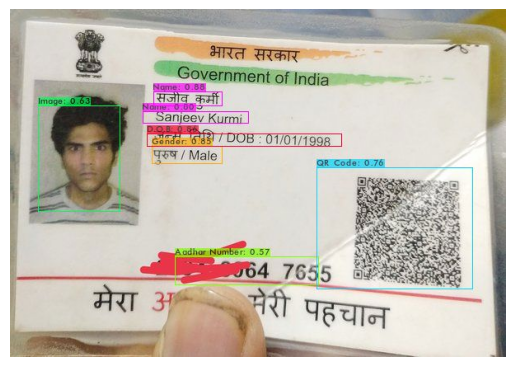

In [ ]:
import cv2
import matplotlib.pyplot as plt

image = cv2.imread('predictions.jpg')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()
